# 多层全连接神经网络

## 1 线性模型

### 1.1 一维线性回归

In [1]:
import torch
import numpy as np
from torch import nn, optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

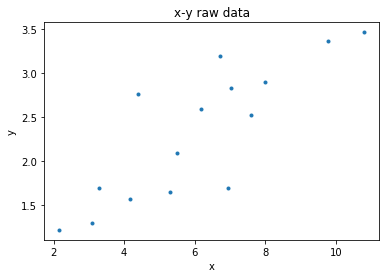

In [2]:
# 1.创建数据
x_train = np.array([3.3, 4.4, 5.5, 6.71, 6.93, 4.168, 9.779, 6.182, 7.59,\
                    2.167, 7.042, 10.791, 5.313, 7.997, 3.1], dtype=np.float32)
y_train = np.array([1.7, 2.76, 2.09, 3.19, 1.694, 1.573, 3.366, 2.596, 2.53, 1.221,\
                   2.827, 3.465, 1.65, 2.904, 1.3], dtype=np.float32)
x_train = np.reshape(x_train, [-1, 1])  # 转换为列向量
y_train = np.reshape(y_train, [-1, 1])
plt.plot(x_train, y_train, '.')
plt.title('x-y raw data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
# 将numpy的数据转换为torch的tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_train.shape

torch.Size([15, 1])

In [4]:
# 2.构建一维线性回归模型，即 y = w*x + b
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()              # python3中继承类的初始化方法
        self.linear = nn.Linear(1, 1)   # 定义一维的输入和输出
    def forward(self, x):               # 模型的前向传播
        output = self.linear(x)         # 计算output=w*x+b
        return output

In [5]:
# 3.实例化一个模型，并定义损失函数和优化函数
# if torch.cuda.is_available():
#     model = LinearRegression().cuda()   # 将模型放到GPU上执行
# else:
#     model = LinearRegression()
model = LinearRegression().cuda() if torch.cuda.is_available() else LinearRegression()
print('1.一维线性回归模型:\n',model)
criterion = nn.MSELoss()                             # 使用均分误差损失
optimizer = optim.SGD(model.parameters(), lr=1e-3)   # 使用SGD优化方法

1.一维线性回归模型:
 LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [6]:
# 4.开始训练模型
num_epochs = 300
# 先将训练数据变为Variable
inputs, target = (Variable(x_train).cuda(), Variable(y_train).cuda()) \
                if torch.cuda.is_available() \
                else (Variable(x_train), Variable(y_train))
for epoch in range(num_epochs):
    # forward
    out = model(inputs)                # 先进行前向传播
    loss = criterion(out, target)      # 计算损失函数
    # backward
    optimizer.zero_grad()              # 每次反向传播先归零梯度
    loss.backward()                    # 反向传播
    optimizer.step()                   # 更新参数
    # validate
    if (epoch + 1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'.format(epoch+1, num_epochs, loss.data[0]))

Epoch[20/300], loss: 0.587414
Epoch[40/300], loss: 0.542969
Epoch[60/300], loss: 0.538063
Epoch[80/300], loss: 0.534261
Epoch[100/300], loss: 0.530526
Epoch[120/300], loss: 0.526829
Epoch[140/300], loss: 0.523171
Epoch[160/300], loss: 0.519550
Epoch[180/300], loss: 0.515966
Epoch[200/300], loss: 0.512418
Epoch[220/300], loss: 0.508907
Epoch[240/300], loss: 0.505432
Epoch[260/300], loss: 0.501992
Epoch[280/300], loss: 0.498588
Epoch[300/300], loss: 0.495218


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


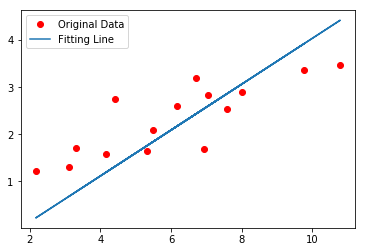

In [7]:
# 5.评估模型性能
# %pylab    
model.eval()                     # 模型变成测试模式
model.cpu()
predict = model(inputs)          # 对输入数据的输出进行预测
predict = predict.data.numpy()   # 转换为numpy数据才可以画图
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
# 是一条直线，所以顺序不会影响绘图
plt.plot(x_train.numpy(), predict, label='Fitting Line')  
plt.legend(['Original Data', 'Fitting Line'])
plt.show()

小结:
1. 创建数据或数据的读取及预处理
2. 构建网络模型
3. 实例化模型并定义损失函数及优化方法
4. 读入数据训练网络，同时输出准确率的验证结果
5. 测试模型的性能并可视化

### 1.2 多项式回归
每一维特征属性的次数不唯一

In [8]:
# 1.数据的创建和预处理
def make_features(x):
    """使数据X处理为多项式矩阵[x, x^2, x^3]"""
    x =x.unsqueeze(1)            # 参数1变为列向量，参数0变为行向量
    # 拼接的是tensor组成的列表，1表示按列拼接，0表示按行拼接 (0行1列)
    return torch.cat([x**i for i in range(1,4)], 1)   # 按列拼接为矩阵
# 使数据满足y=0.9+0.5*x+3*x^2+2.4*x^3关系，向量化为y = X*W + b
w_target = torch.Tensor([0.5, 3, 2.4]).unsqueeze(1)   # 权重变为列向量
b_target = torch.Tensor([0.9])
def func(x):    # 构建函数关系式
    return x.mm(w_target) + b_target    # y = X*W + b，得到列向量

test = torch.Tensor([1,2,3,4,5,6,7])
test_out = make_features(test)
print('1.拼接后的矩阵:\n', test_out)
out = func(test_out)
print('2.满足多项式的输出:\n', out)

1.拼接后的矩阵:
 tensor([[   1.,    1.,    1.],
        [   2.,    4.,    8.],
        [   3.,    9.,   27.],
        [   4.,   16.,   64.],
        [   5.,   25.,  125.],
        [   6.,   36.,  216.],
        [   7.,   49.,  343.]])
2.满足多项式的输出:
 tensor([[   6.8000],
        [  33.1000],
        [  94.2000],
        [ 204.5000],
        [ 378.4000],
        [ 630.3000],
        [ 974.6000]])


In [9]:
# 上述函数合并为一个process_data
def process_data(input_x):           # 预处理数据
    input_x = input_x.unsqueeze(1)   # 得到列向量
    concat_x = torch.cat([input_x**i for i in range(1,4)], 1)  # 按列拼接为矩阵
    w_target = torch.Tensor([0.5, 3, 2.4]).unsqueeze(1)        # 权重变为列向量
    b_target = torch.Tensor([0.9])
    output_y = concat_x.mm(w_target) + b_target                # 使数据符合多项式
    return concat_x, output_y
# test = torch.Tensor([1,2,3,4,5,6,7])
# x, y = process_data(test)
def get_batch(batch_size=32):      # 返回batch_size的(x,y)数据对用于训练
    random_data = torch.randn(batch_size)            # 随机产生高斯分布的数据
    x_train, y_train = process_data(random_data)     # 产生符合要求的数据
    inputs, target = (Variable(x_train).cuda(), Variable(y_train).cuda()) \
                if torch.cuda.is_available() \
                else (Variable(x_train), Variable(y_train))
    return inputs, target

In [10]:
# 2.构建模型并定义损失函数及优化方法
# 定义模型
class poly_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.poly = nn.Linear(3,1)   # y = X*W + b, x为3维，y为1维
    def forward(self, x):
        return self.poly(x)
model = poly_model().cuda() if torch.cuda.is_available() else poly_model()
# 定义损失函数与优化方法
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [11]:
# 3.训练模型
epoch = 0
while True:
    batch_x, batch_y = get_batch()       # 获取数据
    output = model(batch_x)              # 前向传播
    loss = criterion(output, batch_y)    # 计算损失函数
    print_loss = loss.data[0]
    optimizer.zero_grad()                # 梯度归零
    loss.backward()                      # 误差反向传播
    optimizer.step()                     # 更新参数
    epoch += 1        
    if print_loss < 1e-3:
        break
    if epoch % 100 == 0:
        print('Epoch[{}], loss: {:.6f}'.format(epoch+1, print_loss))

Epoch[101], loss: 3.901002
Epoch[201], loss: 1.289163
Epoch[301], loss: 1.368877
Epoch[401], loss: 0.175868
Epoch[501], loss: 0.125882
Epoch[601], loss: 0.108909
Epoch[701], loss: 0.056749
Epoch[801], loss: 0.062572
Epoch[901], loss: 0.033140
Epoch[1001], loss: 0.032642
Epoch[1101], loss: 0.031960


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Epoch[1201], loss: 0.030965
Epoch[1301], loss: 0.023515
Epoch[1401], loss: 0.015178
Epoch[1501], loss: 0.011686
Epoch[1601], loss: 0.013637
Epoch[1701], loss: 0.005364
Epoch[1801], loss: 0.006174
Epoch[1901], loss: 0.005543
Epoch[2001], loss: 0.004586
Epoch[2101], loss: 0.004654
Epoch[2201], loss: 0.003478
Epoch[2301], loss: 0.002655
Epoch[2401], loss: 0.005192
Epoch[2501], loss: 0.002268
Epoch[2601], loss: 0.003116


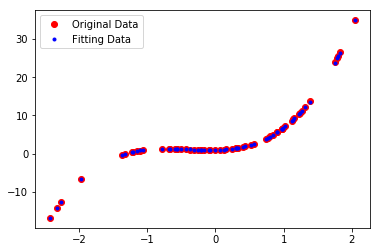

In [12]:
# 4.评估模型性能
# %pylab    
model.eval()                     # 模型变成测试模式
model.cpu()
test_x, test_y = get_batch(64)
predict = model(test_x)          # 对输入数据的输出进行预测
predict = predict.data.numpy()   # 转换为numpy数据才可以画图
test_x = test_x[:,0].unsqueeze(1)
plt.plot(test_x.numpy(), test_y.numpy(), 'ro', label='Original Data')
# 由于数据大小顺序是乱的，故无法画出直线？？？
plt.plot(test_x.numpy(), predict, 'b.',label='Fitting Data')
plt.legend(['Original Data', 'Fitting Data'])
plt.show()

## 2 分类问题

### 2.1 Logistic回归
Logistic回归中，输出y=1的对数概率是x的线性函数：

1. 拟合决策边界(线性或多项式都行)
2. 建立决策边界和分类概率的关系，得到分类概率

In [13]:
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.autograd import Variable

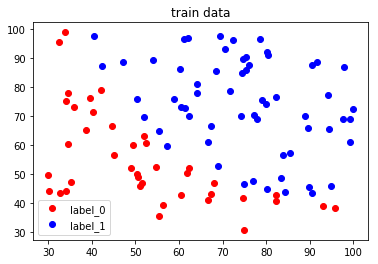

In [14]:
# 1.读取数据
def get_data(file_name):
    with open(file_name) as file:
        data_list = file.read().split('\n')     # 使用readlines会包含回车符
        # 使用map函数将子列表的每个元素转换为float
        data_list = [list(map(float, row.split(','))) for row in data_list]
        # 使用filter函数过滤数据，两类数据分开
        label0 = np.array(list(filter(lambda x: x[-1]==0, data_list)))
        label1 = np.array(list(filter(lambda x: x[-1]==1, data_list)))
    x0, y0 = label0[:, 0], label0[:, 1]
    x1, y1 = label1[:, 0], label1[:, 1]
    plt.plot(x0, y0, 'ro', label='label_0')
    plt.plot(x1, y1, 'bo', label='label_1')
    plt.legend(loc='best')
    plt.title('train data')
#     plt.show()
    x_train = np.concatenate((label0[:,:2], label1[:, :2]), axis=0)  # 按行拼接
    y_train = np.array([0]*label0.shape[0] + [1]*label1.shape[0])    # 构建label
    data_train = np.concatenate((x_train, y_train[:,np.newaxis]), axis=1)
#     print(x_train.shape, y_train[:,np.newaxis].shape)
    return data_train        # 返回 numpy格式的训练数据
data = get_data('data.txt')

In [15]:
# 产生训练模型的batch数据
import random

def get_batch(data, batch_size=32):
    train_data = data
    random.shuffle(train_data)         # 打乱数据的顺序
    while True:
        if len(train_data) > batch_size:
            yield train_data[:batch_size]
            train_data = train_data[batch_size:]
        else:
            yield train_data
            train_data = data
            random.shuffle(train_data)   
g = get_batch(data)

In [27]:
next(g).shape

(4, 3)